In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [2]:
class GraphOperation(ABC):
    def __init__(self, graph):
        self.graph = graph

    @abstractmethod
    def operate(self):
        pass

    def plot_graph(self, result_graph, title):
        """Utility function to plot the resulting graph."""
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(result_graph)
        nx.draw(result_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray')
        plt.title(title)
        plt.show()

# Unary Graph Operation class
class UnaryGraphOperation(GraphOperation):
    def __init__(self, graph, operation):
        super().__init__(graph)
        self.operation = operation

    def operate(self):
        """Handle unary operations."""
        if self.operation == 'shadow':
            return self.shadow()
        elif self.operation == 'splitting':
            return self.splitting()
        elif self.operation == 'total':
            return self.total()
        elif self.operation == 'middle':
            return self.middle()

    def shadow(self):
        shadow = nx.Graph()
        shadow.add_nodes_from(self.graph.nodes)
        shadow.add_edges_from(self.graph.edges)

        shadow_nodes = {}
        for node in self.graph.nodes:
            shadow_node = f"{node}'"
            shadow.add_node(shadow_node)
            shadow_nodes[node] = shadow_node
            for neighbor in self.graph.neighbors(node):
                shadow.add_edge(shadow_node, neighbor)

        shadow_node_list = list(shadow_nodes.values())
        for i in range(len(shadow_node_list)):
            for j in range(i + 1, len(shadow_node_list)):
                shadow.add_edge(shadow_node_list[i], shadow_node_list[j])

        return shadow

    def splitting(self):
        splitting = nx.Graph()
        splitting.add_nodes_from(self.graph.nodes)
        splitting.add_edges_from(self.graph.edges)

        for node in self.graph.nodes:
            shadow_node = f"{node}'"
            splitting.add_node(shadow_node)

            for neighbor in self.graph.neighbors(node):
                splitting.add_edge(shadow_node, neighbor)

        return splitting

    def total(self):
        total = nx.Graph()
        for v in self.graph.nodes:
            total.add_node(v, type='vertex')
        for e in self.graph.edges:
            total.add_node(e, type='edge')

        for v in self.graph.nodes:
            for e in self.graph.edges(v):
                total.add_edge(v, e)

        for e1 in self.graph.edges:
            for e2 in self.graph.edges:
                if e1 != e2 and (e1[0] in e2 or e1[1] in e2):
                    total.add_edge(e1, e2)

        for v1 in self.graph.nodes:
            for v2 in self.graph.neighbors(v1):
                total.add_edge(v1, v2)

        return total

    def middle(self):
        middle = nx.Graph()

        for v in self.graph.nodes:
            middle.add_node(v, type='vertex')

        edge_vertices = {tuple(sorted(e)): f"e{e}" for e in self.graph.edges}
        for edge, edge_vertex in edge_vertices.items():
            middle.add_node(edge_vertex, type='edge')

        for e1 in self.graph.edges:
            for e2 in self.graph.edges:
                if e1 != e2 and (e1[0] in e2 or e1[1] in e2):
                    middle.add_edge(edge_vertices[tuple(sorted(e1))], edge_vertices[tuple(sorted(e2))])

        for v in self.graph.nodes:
            for e in self.graph.edges(v):
                middle.add_edge(v, edge_vertices[tuple(sorted(e))])

        return middle

In [3]:
class BinaryGraphOperation(GraphOperation):
    def __init__(self, graph1, graph2, operation, k=None):
        super().__init__(graph1)
        self.graph1 = graph1
        self.graph2 = graph2
        self.operation = operation
        self.k = k

    def operate(self):
        """Handle binary operations."""
        if self.operation == 'complement':
            return nx.complement(self.graph1)
        elif self.operation == 'line_graph':
            return nx.line_graph(self.graph1)
        elif self.operation == 'kth_power':
            return self.kth_power()
        elif self.operation == 'lexicographic':
            return nx.lexicographic_product(self.graph1, self.graph2)
        elif self.operation == 'tensor':
            return nx.cartesian_product(self.graph1, self.graph2)
        elif self.operation == 'corona':
            return nx.corona_product(self.graph1, self.graph2)
        elif self.operation == 'strong':
            return nx.algorithms.product.strong_product(self.graph1, self.graph2)
        elif self.operation == 'modular':
            return nx.algorithms.product.modular_product(self.graph1, self.graph2)

    def kth_power(self):
        """Calculate the k-th power of the graph."""
        G_power = nx.Graph()
        G_power.add_nodes_from(self.graph1.nodes())
        for u in self.graph1.nodes():
            for v in self.graph1.nodes():
                if u != v and nx.shortest_path_length(self.graph1, source=u, target=v) <= self.k:
                    G_power.add_edge(u, v)
        return G_power

In [4]:
class GraphOperationsManager:
    def __init__(self):
        self.graphs = {}

    def add_graph(self, name, graph_func, *args, **kwargs):
        """Encapsulate the addition of graphs."""
        self.graphs[name] = graph_func(*args, **kwargs)

    def get_graph(self, name):
        """Retrieve the graph."""
        return self.graphs.get(name, None)

    def execute_unary_operation(self, graph_name, operation):
        graph = self.get_graph(graph_name)
        if not graph:
            graph = self.auto_generate_graph(graph_name)
            self.add_graph(graph_name, nx.Graph, graph)

        unary_operation = UnaryGraphOperation(graph, operation)
        result_graph = unary_operation.operate()
        unary_operation.plot_graph(result_graph, f"{operation.capitalize()} of {graph_name}")
    
    def execute_binary_operation(self, graph_name1, graph_name2, operation, k=None):
        graph1 = self.get_graph(graph_name1)
        graph2 = self.get_graph(graph_name2)

        if not graph1:
            graph1 = self.auto_generate_graph(graph_name1)
            self.add_graph(graph_name1, nx.Graph, graph1)

        if not graph2:
            graph2 = self.auto_generate_graph(graph_name2)
            self.add_graph(graph_name2, nx.Graph, graph2)

        binary_operation = BinaryGraphOperation(graph1, graph2, operation, k)
        result_graph = binary_operation.operate()
        binary_operation.plot_graph(result_graph, f"{operation.capitalize()} of {graph_name1} and {graph_name2}")

    def auto_generate_graph(self, graph_name):
        """Automatically generate a graph if not found."""
        if graph_name == 'C5':
            return nx.cycle_graph(5)
        elif graph_name == 'K5':
            return nx.complete_graph(5)
        elif graph_name == 'P3':
            return nx.path_graph(3)
        else:
            return nx.cycle_graph(5)

def user_input_for_operation():
    print("Choose operation type (1: Unary, 2: Binary): ")
    operation_type = input()

    if operation_type == '1':  # Unary Operation
        print("Enter the graph name for the unary operation: ")
        graph_name = input()

        print("Choose unary operation (shadow, splitting, total, middle): ")
        operation = input()

        return 'unary', graph_name, operation

    elif operation_type == '2':  # Binary Operation
        print("Enter the first graph name: ")
        graph_name1 = input()

        print("Enter the second graph name: ")
        graph_name2 = input()

        print("Choose binary operation (complement, line_graph, kth_power, lexicographic, tensor, corona, strong, modular): ")
        operation = input()

        print("If the operation requires k (for kth_power), enter the value of k: ")
        k = input()

        return 'binary', graph_name1, graph_name2, operation, k

    else:
        print("Invalid choice. Exiting.")
        return None

In [5]:
def main():
    manager = GraphOperationsManager()

    # Automatically add some predefined graphs
    manager.add_graph('C5', nx.cycle_graph, 5)
    manager.add_graph('K5', nx.complete_graph, 5)

    # Get user input for the operation
    operation_type, *operation_params = user_input_for_operation()

    if operation_type == 'unary':
        graph_name, operation = operation_params
        manager.execute_unary_operation(graph_name, operation)
    
    elif operation_type == 'binary':
        graph_name1, graph_name2, operation, k = operation_params
        manager.execute_binary_operation(graph_name1, graph_name2, operation, k)

Choose operation type (1: Unary, 2: Binary): 


 1


Enter the graph name for the unary operation: 


 K5


Choose unary operation (shadow, splitting, total, middle): 


 shadow


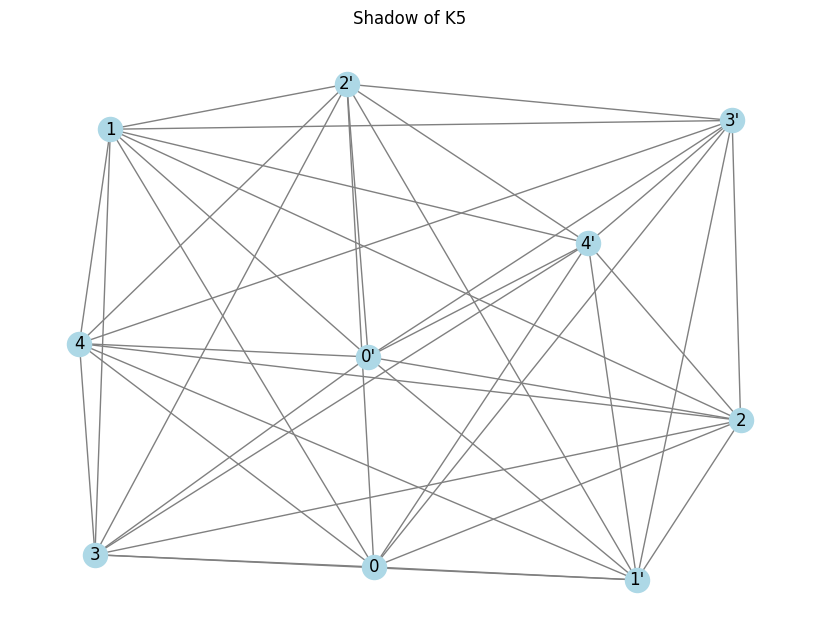

In [6]:
if __name__ == "__main__":
    main()
